# GAN
- 출처: 모두의 딥러닝 개정 3판


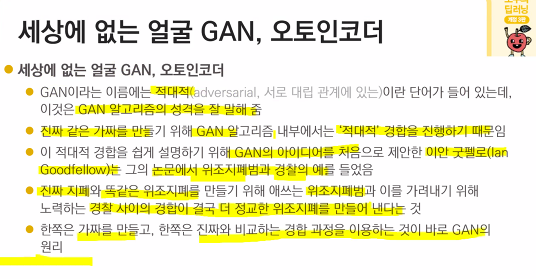

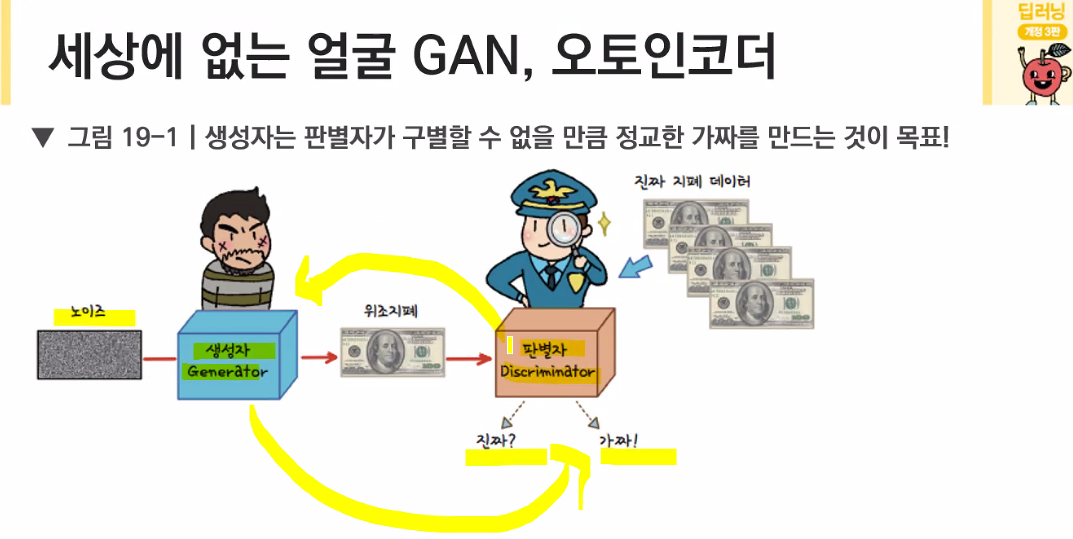

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 예제 파일에서 data 폴더 아래에 이미지가 저장될 gan_images 폴더가 함께 제공됩니다.
# 만약 이미지가 저장될 폴더가 없다면 아래 코드의 주석을 해제해 gan_images 폴더를 만듭니다.
import os
if not os.path.exists("../data/gan_images"):
       os.makedirs("../data/gan_images")

# 1. 생성자 모델 generator

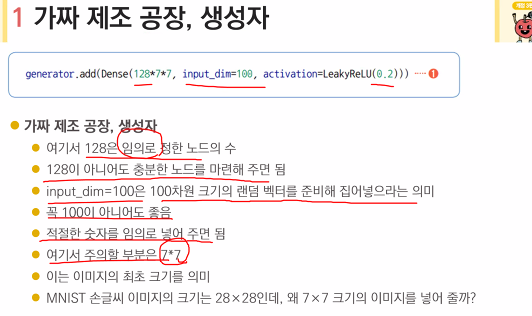

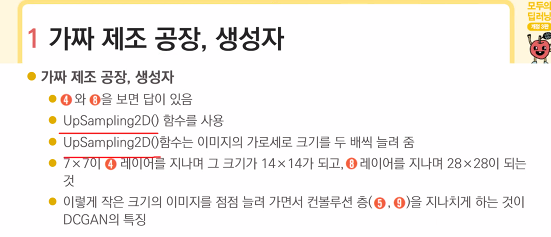

In [3]:
# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D()) # 14 x 14
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # 28 x 28 -> mnist처럼 
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 2. 판별자 모델 discriminator
- 생성자는 만들어서 discriminator에게 주는거기 때문에 complie()이 없다.
- 판별자는 가중치끈다.

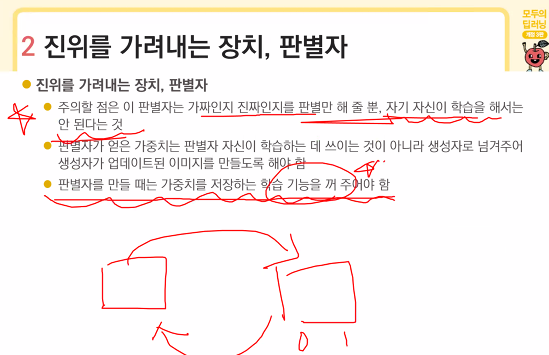

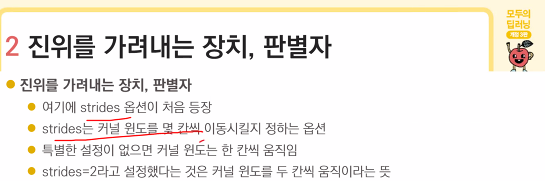

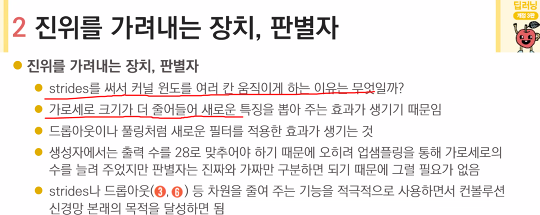

In [4]:
# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 3. 생성자-판별자 연결해 GAN을 만든다

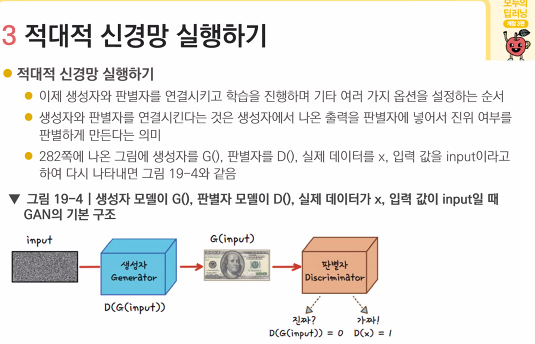

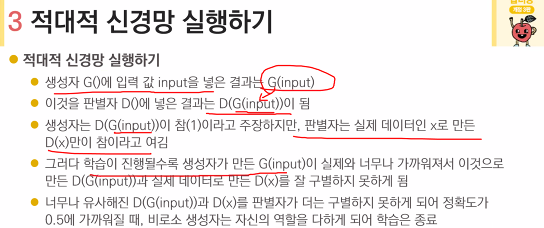

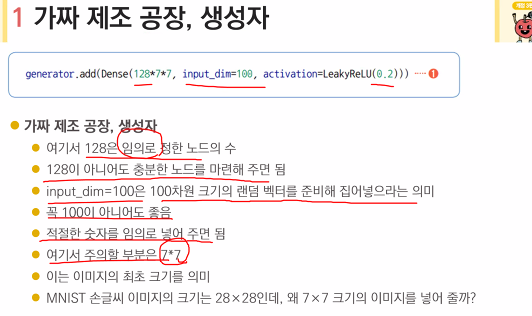

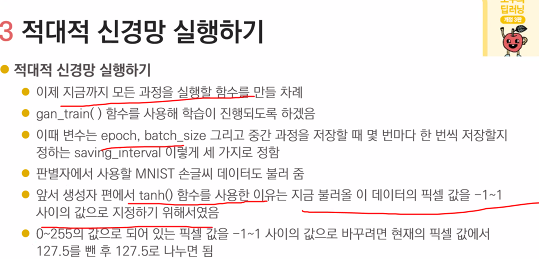

In [5]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [9]:

# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

        (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
        X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
        X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
        # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

        true = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        

        for i in range(epoch):
            # 실제 데이터를 판별자에 입력하는 부분입니다.
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            d_loss_real = discriminator.train_on_batch(imgs, true)

            # 가상 이미지를 판별자에 입력하는 부분입니다.
            noise = np.random.normal(0, 1, (batch_size, 100))
            gen_imgs = generator.predict(noise)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

            # 판별자와 생성자의 오차를 계산합니다.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = gan.train_on_batch(noise, true)

            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

            # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
            # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
            if i % saving_interval == 0:
                #r, c = 5, 5
                noise = np.random.normal(0, 1, (25, 100))
                gen_imgs = generator.predict(noise)

                # Rescale images 0 - 1
                gen_imgs = 0.5 * gen_imgs + 0.5

                fig, axs = plt.subplots(5, 5)
                count = 0
                for j in range(5):
                    for k in range(5):
                        axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                        axs[j, k].axis('off')
                        count += 1
                fig.savefig("../data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 27ms/step
epoch:0  d_loss:0.4551  g_loss:0.1244
1/1 [==============================] - 0s 27ms/step
epoch:1  d_loss:0.5238  g_loss:0.0288
1/1 [==============================] - 0s 25ms/step
epoch:2  d_loss:0.6304  g_loss:0.0322
1/1 [==============================] - 0s 33ms/step
epoch:3  d_loss:0.6185  g_loss:0.1145
1/1 [==============================] - 0s 35ms/step
epoch:4  d_loss:0.5007  g_loss:0.4122
1/1 [==============================] - 0s 32ms/step
epoch:5  d_loss:0.4593  g_loss:0.8487
1/1 [==============================] - 0s 32ms/step
epoch:6  d_loss:0.4921  g_loss:1.0544
1/1 [==============================] - 0s 26ms/step
epoch:7  d_loss:0.5005  g_loss:1.0396
1/1 [==============================] - 0s 30ms/step
epoch:8  d_loss:0.4357  g_loss:1.0297
1/1 [==============================] - 0s 30ms/step
epoch:9  d_loss:0.4318  g_loss:0.9684
1/1 [==============================] - 0s 50ms/step
epoch:10  d_loss:0.4477  g_loss:0.8408
1/1 [====

epoch:89  d_loss:0.3706  g_loss:3.1448
1/1 [==============================] - 0s 29ms/step
epoch:90  d_loss:0.3698  g_loss:3.0968
1/1 [==============================] - 0s 26ms/step
epoch:91  d_loss:0.9347  g_loss:2.6207
1/1 [==============================] - 0s 32ms/step
epoch:92  d_loss:0.4236  g_loss:4.2725
1/1 [==============================] - 0s 38ms/step
epoch:93  d_loss:0.9773  g_loss:3.7428
1/1 [==============================] - 0s 26ms/step
epoch:94  d_loss:1.1241  g_loss:2.5271
1/1 [==============================] - 0s 25ms/step
epoch:95  d_loss:1.0535  g_loss:1.4006
1/1 [==============================] - 0s 28ms/step
epoch:96  d_loss:0.9318  g_loss:1.3838
1/1 [==============================] - 0s 29ms/step
epoch:97  d_loss:0.8670  g_loss:1.4759
1/1 [==============================] - 0s 36ms/step
epoch:98  d_loss:0.8441  g_loss:1.3262
1/1 [==============================] - 0s 35ms/step
epoch:99  d_loss:0.5479  g_loss:1.7538
1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 26ms/step
epoch:179  d_loss:0.5224  g_loss:1.8234
1/1 [==============================] - 0s 27ms/step
epoch:180  d_loss:0.3975  g_loss:1.7714
1/1 [==============================] - 0s 26ms/step
epoch:181  d_loss:0.4960  g_loss:1.3788
1/1 [==============================] - 0s 27ms/step
epoch:182  d_loss:0.4663  g_loss:1.2561
1/1 [==============================] - 0s 25ms/step
epoch:183  d_loss:0.4489  g_loss:1.4630
1/1 [==============================] - 0s 25ms/step
epoch:184  d_loss:0.5890  g_loss:1.5412
1/1 [==============================] - 0s 29ms/step
epoch:185  d_loss:0.6329  g_loss:1.6401
1/1 [==============================] - 0s 24ms/step
epoch:186  d_loss:0.5237  g_loss:1.4366
1/1 [==============================] - 0s 27ms/step
epoch:187  d_loss:0.5480  g_loss:1.3570
1/1 [==============================] - 0s 28ms/step
epoch:188  d_loss:0.4832  g_loss:1.4733
1/1 [==============================] - 0s 27ms/step
epoch:189  d_loss:0.4643  g_

1/1 [==============================] - 0s 27ms/step
epoch:267  d_loss:0.5061  g_loss:1.9288
1/1 [==============================] - 0s 28ms/step
epoch:268  d_loss:0.4270  g_loss:2.1785
1/1 [==============================] - 0s 28ms/step
epoch:269  d_loss:0.3271  g_loss:2.2682
1/1 [==============================] - 0s 29ms/step
epoch:270  d_loss:0.4743  g_loss:1.8014
1/1 [==============================] - 0s 28ms/step
epoch:271  d_loss:0.4103  g_loss:1.9322
1/1 [==============================] - 0s 25ms/step
epoch:272  d_loss:0.4509  g_loss:2.0141
1/1 [==============================] - 0s 25ms/step
epoch:273  d_loss:0.4675  g_loss:1.8028
1/1 [==============================] - 0s 24ms/step
epoch:274  d_loss:0.4619  g_loss:1.9582
1/1 [==============================] - 0s 27ms/step
epoch:275  d_loss:0.3180  g_loss:2.2206
1/1 [==============================] - 0s 25ms/step
epoch:276  d_loss:0.3633  g_loss:2.2018
1/1 [==============================] - 0s 25ms/step
epoch:277  d_loss:0.3323  g_

1/1 [==============================] - 0s 30ms/step
epoch:356  d_loss:0.3836  g_loss:2.7861
1/1 [==============================] - 0s 30ms/step
epoch:357  d_loss:0.4210  g_loss:2.1151
1/1 [==============================] - 0s 30ms/step
epoch:358  d_loss:0.4107  g_loss:2.0708
1/1 [==============================] - 0s 27ms/step
epoch:359  d_loss:0.3429  g_loss:2.1426
1/1 [==============================] - 0s 24ms/step
epoch:360  d_loss:0.4080  g_loss:2.1605
1/1 [==============================] - 0s 24ms/step
epoch:361  d_loss:0.3874  g_loss:1.8594
1/1 [==============================] - 0s 25ms/step
epoch:362  d_loss:0.2850  g_loss:2.4692
1/1 [==============================] - 0s 27ms/step
epoch:363  d_loss:0.3293  g_loss:2.4051
1/1 [==============================] - 0s 27ms/step
epoch:364  d_loss:0.3070  g_loss:2.0967
1/1 [==============================] - 0s 25ms/step
epoch:365  d_loss:0.3087  g_loss:2.1477
1/1 [==============================] - 0s 26ms/step
epoch:366  d_loss:0.4342  g_

1/1 [==============================] - 0s 28ms/step
epoch:444  d_loss:0.3216  g_loss:2.3732
1/1 [==============================] - 0s 26ms/step
epoch:445  d_loss:0.2520  g_loss:2.0334
1/1 [==============================] - 0s 25ms/step
epoch:446  d_loss:0.3023  g_loss:2.3883
1/1 [==============================] - 0s 26ms/step
epoch:447  d_loss:0.2471  g_loss:2.5740
1/1 [==============================] - 0s 26ms/step
epoch:448  d_loss:0.3758  g_loss:2.8283
1/1 [==============================] - 0s 24ms/step
epoch:449  d_loss:0.2565  g_loss:2.7718
1/1 [==============================] - 0s 25ms/step
epoch:450  d_loss:0.4499  g_loss:2.3111
1/1 [==============================] - 0s 27ms/step
epoch:451  d_loss:0.2322  g_loss:1.8512
1/1 [==============================] - 0s 24ms/step
epoch:452  d_loss:0.2705  g_loss:2.4814
1/1 [==============================] - 0s 28ms/step
epoch:453  d_loss:0.1783  g_loss:2.5753
1/1 [==============================] - 0s 24ms/step
epoch:454  d_loss:0.2649  g_

1/1 [==============================] - 0s 24ms/step
epoch:533  d_loss:0.3395  g_loss:1.5734
1/1 [==============================] - 0s 27ms/step
epoch:534  d_loss:0.3922  g_loss:1.3940
1/1 [==============================] - 0s 27ms/step
epoch:535  d_loss:0.3589  g_loss:1.7591
1/1 [==============================] - 0s 25ms/step
epoch:536  d_loss:0.3586  g_loss:1.9257
1/1 [==============================] - 0s 25ms/step
epoch:537  d_loss:0.5907  g_loss:2.0579
1/1 [==============================] - 0s 26ms/step
epoch:538  d_loss:0.3896  g_loss:1.8588
1/1 [==============================] - 0s 25ms/step
epoch:539  d_loss:0.4658  g_loss:1.5443
1/1 [==============================] - 0s 24ms/step
epoch:540  d_loss:0.5993  g_loss:1.7244
1/1 [==============================] - 0s 26ms/step
epoch:541  d_loss:0.3855  g_loss:1.6323
1/1 [==============================] - 0s 26ms/step
epoch:542  d_loss:0.4721  g_loss:1.4209
1/1 [==============================] - 0s 24ms/step
epoch:543  d_loss:0.6160  g_

1/1 [==============================] - 0s 26ms/step
epoch:621  d_loss:0.5377  g_loss:1.4413
1/1 [==============================] - 0s 28ms/step
epoch:622  d_loss:0.6525  g_loss:1.1652
1/1 [==============================] - 0s 25ms/step
epoch:623  d_loss:0.6231  g_loss:1.6082
1/1 [==============================] - 0s 27ms/step
epoch:624  d_loss:0.5360  g_loss:1.7491
1/1 [==============================] - 0s 27ms/step
epoch:625  d_loss:0.3561  g_loss:2.3464
1/1 [==============================] - 0s 25ms/step
epoch:626  d_loss:0.5331  g_loss:1.8025
1/1 [==============================] - 0s 26ms/step
epoch:627  d_loss:0.4467  g_loss:1.7727
1/1 [==============================] - 0s 24ms/step
epoch:628  d_loss:0.3095  g_loss:1.9523
1/1 [==============================] - 0s 26ms/step
epoch:629  d_loss:0.3188  g_loss:2.2634
1/1 [==============================] - 0s 27ms/step
epoch:630  d_loss:0.2777  g_loss:2.5310
1/1 [==============================] - 0s 26ms/step
epoch:631  d_loss:0.3587  g_

1/1 [==============================] - 0s 25ms/step
epoch:710  d_loss:0.2330  g_loss:1.9398
1/1 [==============================] - 0s 25ms/step
epoch:711  d_loss:0.2085  g_loss:2.3695
1/1 [==============================] - 0s 27ms/step
epoch:712  d_loss:0.3666  g_loss:1.8970
1/1 [==============================] - 0s 25ms/step
epoch:713  d_loss:0.3630  g_loss:1.7191
1/1 [==============================] - 0s 25ms/step
epoch:714  d_loss:0.2474  g_loss:2.2376
1/1 [==============================] - 0s 24ms/step
epoch:715  d_loss:0.2219  g_loss:1.7642
1/1 [==============================] - 0s 25ms/step
epoch:716  d_loss:0.2938  g_loss:1.7569
1/1 [==============================] - 0s 24ms/step
epoch:717  d_loss:0.2215  g_loss:2.4439
1/1 [==============================] - 0s 28ms/step
epoch:718  d_loss:0.2905  g_loss:2.2415
1/1 [==============================] - 0s 25ms/step
epoch:719  d_loss:0.2586  g_loss:2.1453
1/1 [==============================] - 0s 26ms/step
epoch:720  d_loss:0.2468  g_

1/1 [==============================] - 0s 26ms/step
epoch:799  d_loss:0.2080  g_loss:3.0178
1/1 [==============================] - 0s 28ms/step
epoch:800  d_loss:0.2941  g_loss:2.5099
1/1 [==============================] - 0s 27ms/step
epoch:801  d_loss:0.3818  g_loss:1.9985
1/1 [==============================] - 0s 27ms/step
epoch:802  d_loss:0.2953  g_loss:1.8960
1/1 [==============================] - 0s 30ms/step
epoch:803  d_loss:0.4084  g_loss:2.1040
1/1 [==============================] - 0s 25ms/step
epoch:804  d_loss:0.4352  g_loss:2.2591
1/1 [==============================] - 0s 25ms/step
epoch:805  d_loss:0.4858  g_loss:2.6617
1/1 [==============================] - 0s 30ms/step
epoch:806  d_loss:0.4974  g_loss:2.2128
1/1 [==============================] - 0s 26ms/step
epoch:807  d_loss:0.5647  g_loss:1.9762
1/1 [==============================] - 0s 25ms/step
epoch:808  d_loss:0.4319  g_loss:1.8040
1/1 [==============================] - 0s 26ms/step
epoch:809  d_loss:0.5953  g_

1/1 [==============================] - 0s 24ms/step
epoch:887  d_loss:0.4781  g_loss:1.8269
1/1 [==============================] - 0s 27ms/step
epoch:888  d_loss:0.5278  g_loss:1.8649
1/1 [==============================] - 0s 25ms/step
epoch:889  d_loss:0.3986  g_loss:2.2408
1/1 [==============================] - 0s 25ms/step
epoch:890  d_loss:0.6459  g_loss:1.4150
1/1 [==============================] - 0s 26ms/step
epoch:891  d_loss:0.4126  g_loss:2.0556
1/1 [==============================] - 0s 25ms/step
epoch:892  d_loss:0.4119  g_loss:2.0651
1/1 [==============================] - 0s 25ms/step
epoch:893  d_loss:0.4166  g_loss:2.0991
1/1 [==============================] - 0s 28ms/step
epoch:894  d_loss:0.5019  g_loss:1.6933
1/1 [==============================] - 0s 25ms/step
epoch:895  d_loss:0.3234  g_loss:1.8722
1/1 [==============================] - 0s 26ms/step
epoch:896  d_loss:0.5104  g_loss:1.6288
1/1 [==============================] - 0s 25ms/step
epoch:897  d_loss:0.5097  g_

1/1 [==============================] - 0s 28ms/step
epoch:976  d_loss:0.4774  g_loss:1.9175
1/1 [==============================] - 0s 26ms/step
epoch:977  d_loss:0.3655  g_loss:1.9694
1/1 [==============================] - 0s 27ms/step
epoch:978  d_loss:0.3644  g_loss:2.1162
1/1 [==============================] - 0s 29ms/step
epoch:979  d_loss:0.3564  g_loss:1.9313
1/1 [==============================] - 0s 26ms/step
epoch:980  d_loss:0.4404  g_loss:2.1432
1/1 [==============================] - 0s 25ms/step
epoch:981  d_loss:0.3310  g_loss:2.0302
1/1 [==============================] - 0s 26ms/step
epoch:982  d_loss:0.3293  g_loss:2.3195
1/1 [==============================] - 0s 27ms/step
epoch:983  d_loss:0.3256  g_loss:2.1084
1/1 [==============================] - 0s 27ms/step
epoch:984  d_loss:0.4390  g_loss:2.1582
1/1 [==============================] - 0s 25ms/step
epoch:985  d_loss:0.2710  g_loss:2.3882
1/1 [==============================] - 0s 26ms/step
epoch:986  d_loss:0.3649  g_

1/1 [==============================] - 0s 26ms/step
epoch:1064  d_loss:0.2818  g_loss:1.9500
1/1 [==============================] - 0s 25ms/step
epoch:1065  d_loss:0.3707  g_loss:1.6410
1/1 [==============================] - 0s 24ms/step
epoch:1066  d_loss:0.3361  g_loss:2.1010
1/1 [==============================] - 0s 26ms/step
epoch:1067  d_loss:0.5197  g_loss:2.2284
1/1 [==============================] - 0s 26ms/step
epoch:1068  d_loss:0.5120  g_loss:1.8789
1/1 [==============================] - 0s 25ms/step
epoch:1069  d_loss:0.3736  g_loss:1.9345
1/1 [==============================] - 0s 25ms/step
epoch:1070  d_loss:0.4397  g_loss:1.8576
1/1 [==============================] - 0s 29ms/step
epoch:1071  d_loss:0.4449  g_loss:1.6401
1/1 [==============================] - 0s 26ms/step
epoch:1072  d_loss:0.5492  g_loss:1.6742
1/1 [==============================] - 0s 28ms/step
epoch:1073  d_loss:0.4202  g_loss:1.8710
1/1 [==============================] - 0s 25ms/step
epoch:1074  d_loss

1/1 [==============================] - 0s 25ms/step
epoch:1152  d_loss:0.3813  g_loss:2.1958
1/1 [==============================] - 0s 24ms/step
epoch:1153  d_loss:0.4611  g_loss:1.9203
1/1 [==============================] - 0s 25ms/step
epoch:1154  d_loss:0.3802  g_loss:1.9336
1/1 [==============================] - 0s 27ms/step
epoch:1155  d_loss:0.5267  g_loss:1.5941
1/1 [==============================] - 0s 25ms/step
epoch:1156  d_loss:0.4984  g_loss:1.2890
1/1 [==============================] - 0s 30ms/step
epoch:1157  d_loss:0.4637  g_loss:1.6935
1/1 [==============================] - 0s 26ms/step
epoch:1158  d_loss:0.3941  g_loss:1.9169
1/1 [==============================] - 0s 25ms/step
epoch:1159  d_loss:0.4222  g_loss:2.2666
1/1 [==============================] - 0s 25ms/step
epoch:1160  d_loss:0.5013  g_loss:2.1460
1/1 [==============================] - 0s 27ms/step
epoch:1161  d_loss:0.5584  g_loss:1.8816
1/1 [==============================] - 0s 26ms/step
epoch:1162  d_loss

epoch:1239  d_loss:0.4988  g_loss:1.9588
1/1 [==============================] - 0s 30ms/step
epoch:1240  d_loss:0.4780  g_loss:1.5865
1/1 [==============================] - 0s 27ms/step
epoch:1241  d_loss:0.3820  g_loss:1.7430
1/1 [==============================] - 0s 25ms/step
epoch:1242  d_loss:0.3912  g_loss:1.7968
1/1 [==============================] - 0s 25ms/step
epoch:1243  d_loss:0.3244  g_loss:2.1609
1/1 [==============================] - 0s 26ms/step
epoch:1244  d_loss:0.4242  g_loss:2.6996
1/1 [==============================] - 0s 26ms/step
epoch:1245  d_loss:0.3662  g_loss:2.0968
1/1 [==============================] - 0s 24ms/step
epoch:1246  d_loss:0.4349  g_loss:1.4584
1/1 [==============================] - 0s 24ms/step
epoch:1247  d_loss:0.4685  g_loss:1.4919
1/1 [==============================] - 0s 26ms/step
epoch:1248  d_loss:0.4025  g_loss:2.0982
1/1 [==============================] - 0s 26ms/step
epoch:1249  d_loss:0.3116  g_loss:2.0780
1/1 [========================

epoch:1327  d_loss:0.3966  g_loss:1.9945
1/1 [==============================] - 0s 25ms/step
epoch:1328  d_loss:0.6141  g_loss:2.1578
1/1 [==============================] - 0s 26ms/step
epoch:1329  d_loss:0.4420  g_loss:1.5613
1/1 [==============================] - 0s 23ms/step
epoch:1330  d_loss:0.5410  g_loss:1.4876
1/1 [==============================] - 0s 24ms/step
epoch:1331  d_loss:0.4662  g_loss:1.1450
1/1 [==============================] - 0s 26ms/step
epoch:1332  d_loss:0.4817  g_loss:1.5801
1/1 [==============================] - 0s 26ms/step
epoch:1333  d_loss:0.4461  g_loss:1.8021
1/1 [==============================] - 0s 24ms/step
epoch:1334  d_loss:0.4510  g_loss:1.7005
1/1 [==============================] - 0s 24ms/step
epoch:1335  d_loss:0.3971  g_loss:1.8601
1/1 [==============================] - 0s 24ms/step
epoch:1336  d_loss:0.4321  g_loss:1.8158
1/1 [==============================] - 0s 25ms/step
epoch:1337  d_loss:0.3677  g_loss:1.9991
1/1 [========================

1/1 [==============================] - 0s 27ms/step
epoch:1415  d_loss:0.3273  g_loss:2.1935
1/1 [==============================] - 0s 25ms/step
epoch:1416  d_loss:0.5081  g_loss:2.2220
1/1 [==============================] - 0s 26ms/step
epoch:1417  d_loss:0.5902  g_loss:2.3949
1/1 [==============================] - 0s 26ms/step
epoch:1418  d_loss:0.5694  g_loss:1.9461
1/1 [==============================] - 0s 25ms/step
epoch:1419  d_loss:0.4531  g_loss:1.8723
1/1 [==============================] - 0s 26ms/step
epoch:1420  d_loss:0.3610  g_loss:1.6871
1/1 [==============================] - 0s 26ms/step
epoch:1421  d_loss:0.4894  g_loss:1.6088
1/1 [==============================] - 0s 24ms/step
epoch:1422  d_loss:0.3488  g_loss:1.8661
1/1 [==============================] - 0s 25ms/step
epoch:1423  d_loss:0.4899  g_loss:1.7542
1/1 [==============================] - 0s 24ms/step
epoch:1424  d_loss:0.4842  g_loss:2.0696
1/1 [==============================] - 0s 26ms/step
epoch:1425  d_loss

1/1 [==============================] - 0s 25ms/step
epoch:1503  d_loss:0.4776  g_loss:1.7650
1/1 [==============================] - 0s 26ms/step
epoch:1504  d_loss:0.4146  g_loss:1.7626
1/1 [==============================] - 0s 25ms/step
epoch:1505  d_loss:0.3924  g_loss:1.5920
1/1 [==============================] - 0s 26ms/step
epoch:1506  d_loss:0.4957  g_loss:1.4172
1/1 [==============================] - 0s 25ms/step
epoch:1507  d_loss:0.2831  g_loss:1.7083
1/1 [==============================] - 0s 26ms/step
epoch:1508  d_loss:0.4251  g_loss:1.8768
1/1 [==============================] - 0s 25ms/step
epoch:1509  d_loss:0.4551  g_loss:2.1033
1/1 [==============================] - 0s 27ms/step
epoch:1510  d_loss:0.5434  g_loss:1.4394
1/1 [==============================] - 0s 28ms/step
epoch:1511  d_loss:0.4371  g_loss:1.6610
1/1 [==============================] - 0s 23ms/step
epoch:1512  d_loss:0.5547  g_loss:1.6039
1/1 [==============================] - 0s 25ms/step
epoch:1513  d_loss

1/1 [==============================] - 0s 24ms/step
epoch:1591  d_loss:0.3736  g_loss:1.5624
1/1 [==============================] - 0s 26ms/step
epoch:1592  d_loss:0.4362  g_loss:1.7648
1/1 [==============================] - 0s 25ms/step
epoch:1593  d_loss:0.5881  g_loss:1.7812
1/1 [==============================] - 0s 24ms/step
epoch:1594  d_loss:0.6170  g_loss:1.6105
1/1 [==============================] - 0s 26ms/step
epoch:1595  d_loss:0.5826  g_loss:1.2620
1/1 [==============================] - 0s 26ms/step
epoch:1596  d_loss:0.4394  g_loss:1.3898
1/1 [==============================] - 0s 25ms/step
epoch:1597  d_loss:0.5221  g_loss:1.7322
1/1 [==============================] - 0s 25ms/step
epoch:1598  d_loss:0.5255  g_loss:1.5611
1/1 [==============================] - 0s 26ms/step
epoch:1599  d_loss:0.3695  g_loss:1.9295
1/1 [==============================] - 0s 29ms/step
epoch:1600  d_loss:0.6769  g_loss:1.8665
1/1 [==============================] - 0s 27ms/step
epoch:1601  d_loss

epoch:1678  d_loss:0.5226  g_loss:1.5375
1/1 [==============================] - 0s 26ms/step
epoch:1679  d_loss:0.5021  g_loss:1.4433
1/1 [==============================] - 0s 24ms/step
epoch:1680  d_loss:0.5387  g_loss:1.3984
1/1 [==============================] - 0s 30ms/step
epoch:1681  d_loss:0.5837  g_loss:1.4324
1/1 [==============================] - 0s 26ms/step
epoch:1682  d_loss:0.3661  g_loss:1.7537
1/1 [==============================] - 0s 24ms/step
epoch:1683  d_loss:0.3634  g_loss:1.7135
1/1 [==============================] - 0s 27ms/step
epoch:1684  d_loss:0.3990  g_loss:1.5070
1/1 [==============================] - 0s 35ms/step
epoch:1685  d_loss:0.5505  g_loss:1.7871
1/1 [==============================] - 0s 26ms/step
epoch:1686  d_loss:0.4691  g_loss:1.6715
1/1 [==============================] - 0s 26ms/step
epoch:1687  d_loss:0.4434  g_loss:1.6638
1/1 [==============================] - 0s 24ms/step
epoch:1688  d_loss:0.4812  g_loss:1.8037
1/1 [========================

epoch:1766  d_loss:0.4661  g_loss:1.5468
1/1 [==============================] - 0s 27ms/step
epoch:1767  d_loss:0.4655  g_loss:1.6627
1/1 [==============================] - 0s 24ms/step
epoch:1768  d_loss:0.5053  g_loss:1.8631
1/1 [==============================] - 0s 23ms/step
epoch:1769  d_loss:0.4514  g_loss:2.1102
1/1 [==============================] - 0s 26ms/step
epoch:1770  d_loss:0.5025  g_loss:1.7951
1/1 [==============================] - 0s 30ms/step
epoch:1771  d_loss:0.3948  g_loss:1.3959
1/1 [==============================] - 0s 25ms/step
epoch:1772  d_loss:0.5098  g_loss:1.3461
1/1 [==============================] - 0s 26ms/step
epoch:1773  d_loss:0.4340  g_loss:1.2606
1/1 [==============================] - 0s 27ms/step
epoch:1774  d_loss:0.6001  g_loss:1.3906
1/1 [==============================] - 0s 25ms/step
epoch:1775  d_loss:0.3511  g_loss:1.6756
1/1 [==============================] - 0s 27ms/step
epoch:1776  d_loss:0.5461  g_loss:1.3540
1/1 [========================

1/1 [==============================] - 0s 26ms/step
epoch:1854  d_loss:0.5346  g_loss:1.3360
1/1 [==============================] - 0s 26ms/step
epoch:1855  d_loss:0.5205  g_loss:1.5101
1/1 [==============================] - 0s 26ms/step
epoch:1856  d_loss:0.5145  g_loss:1.4299
1/1 [==============================] - 0s 25ms/step
epoch:1857  d_loss:0.6528  g_loss:1.2135
1/1 [==============================] - 0s 25ms/step
epoch:1858  d_loss:0.6800  g_loss:1.6364
1/1 [==============================] - 0s 25ms/step
epoch:1859  d_loss:0.5893  g_loss:1.2531
1/1 [==============================] - 0s 26ms/step
epoch:1860  d_loss:0.6024  g_loss:1.5708
1/1 [==============================] - 0s 24ms/step
epoch:1861  d_loss:0.5224  g_loss:1.5253
1/1 [==============================] - 0s 26ms/step
epoch:1862  d_loss:0.6456  g_loss:1.5654
1/1 [==============================] - 0s 25ms/step
epoch:1863  d_loss:0.4777  g_loss:1.2587
1/1 [==============================] - 0s 24ms/step
epoch:1864  d_loss

1/1 [==============================] - 0s 28ms/step
epoch:1942  d_loss:0.4804  g_loss:1.6879
1/1 [==============================] - 0s 26ms/step
epoch:1943  d_loss:0.3739  g_loss:1.7585
1/1 [==============================] - 0s 25ms/step
epoch:1944  d_loss:0.3416  g_loss:1.8118
1/1 [==============================] - 0s 24ms/step
epoch:1945  d_loss:0.3097  g_loss:2.3340
1/1 [==============================] - 0s 25ms/step
epoch:1946  d_loss:0.4444  g_loss:1.9436
1/1 [==============================] - 0s 25ms/step
epoch:1947  d_loss:0.5120  g_loss:1.4809
1/1 [==============================] - 0s 24ms/step
epoch:1948  d_loss:0.5311  g_loss:1.7477
1/1 [==============================] - 0s 24ms/step
epoch:1949  d_loss:0.4816  g_loss:1.7568
1/1 [==============================] - 0s 25ms/step
epoch:1950  d_loss:0.6001  g_loss:1.3631
1/1 [==============================] - 0s 25ms/step
epoch:1951  d_loss:0.5047  g_loss:1.3302
1/1 [==============================] - 0s 27ms/step
epoch:1952  d_loss

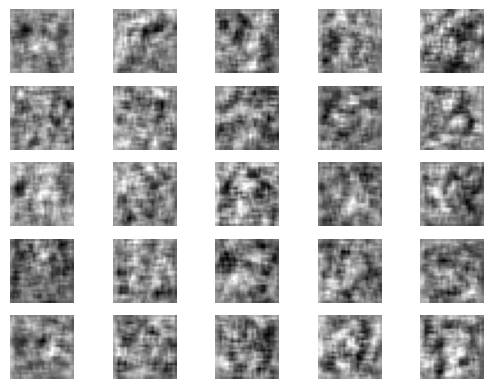

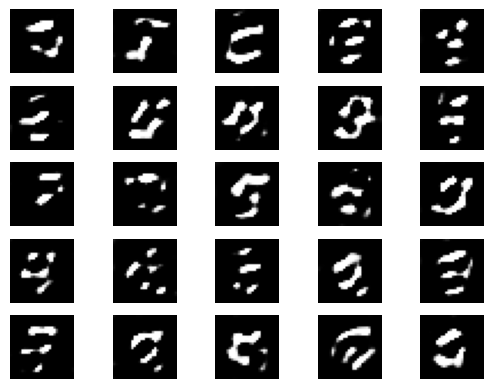

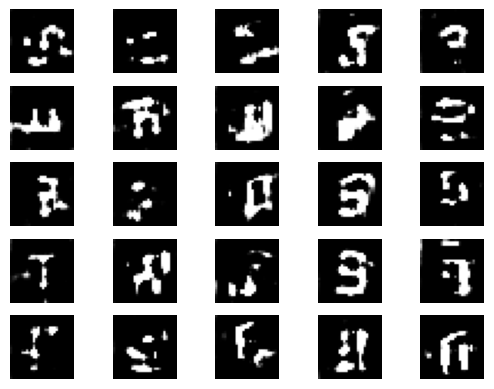

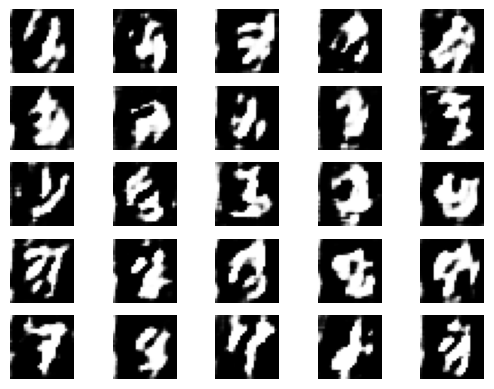

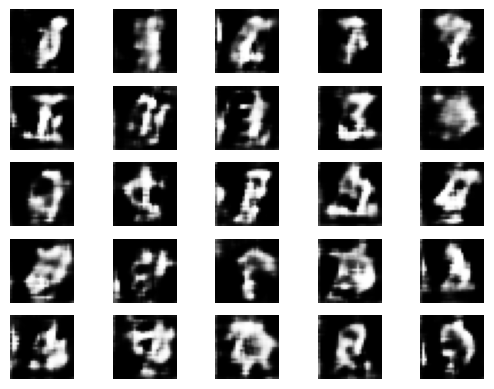

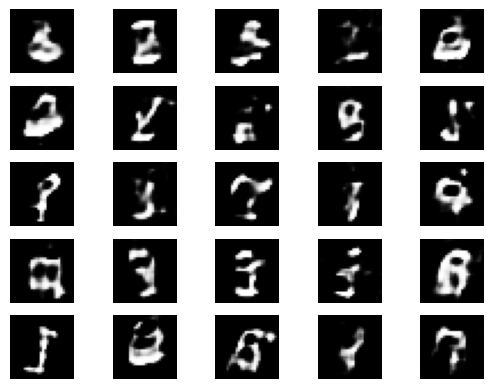

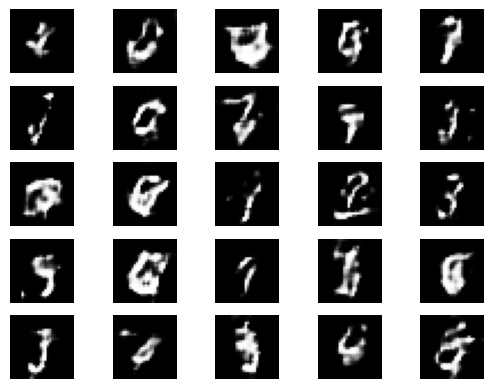

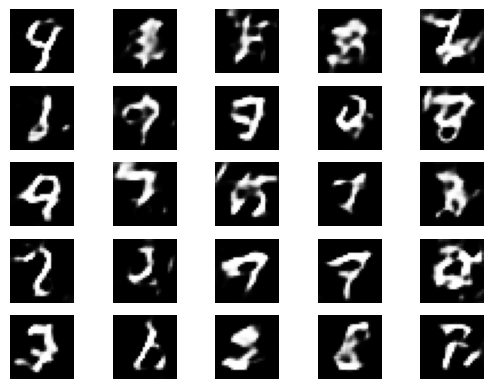

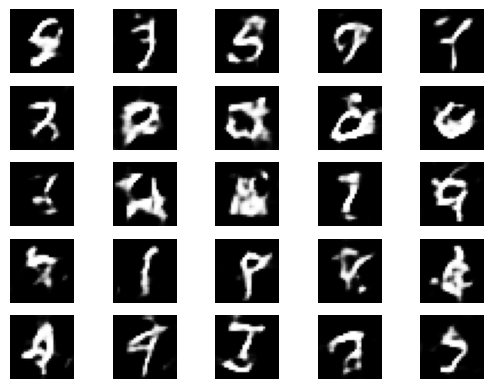

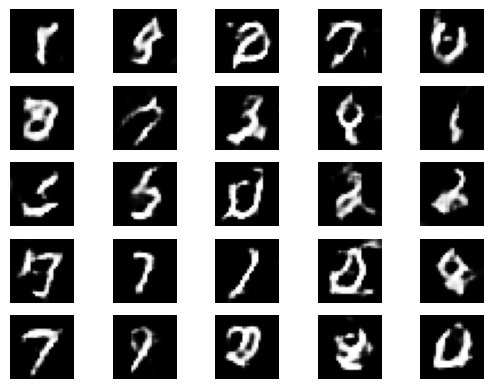

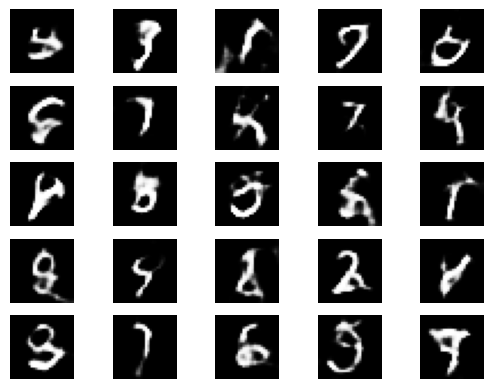

In [10]:
gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.